In [176]:
import torch
from torch import nn
import torch.nn.functional as F
from e3nn import o3
import e3nn
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_add_pool
from torch_geometric.datasets import MD17
from torch_geometric.transforms import AddSelfLoops, RadiusGraph

# exercise sheet 11

## exercise 1
Why is density fitting needed? What metric do they use to fit the densities?

Density fitting is needed because the representation of the densities is different in Kohn-Sham and the mofdft-network. We need to fit the density coefficients, which will be the input of the network to the Kohn-Sham solution.

The metric they use is the Hartree energy plus the external energy, because they say it is the more important quantity, because it is the physical quantity.

## exercise 2

In this exercise, we will predict energies from the MD17 dataset, which contains molecular dynamics
simulations for specific molecules (we will take a look at ethanol). Here the relative distance between
the atoms is important and therefore we can’t use the GCNConv layer from before, because it does not
take into account the atomic positions.

In [177]:
# Load MD17 dataset
dataset = MD17(root='data/MD17', name="revised ethanol", transform=RadiusGraph(5.0))

target_idx = 0  # internal energy

# Split dataset
train_dataset = dataset[:1000]
val_dataset = dataset[1100:1200]
test_dataset = dataset[1200:1300]

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

sample = next(iter(train_loader))

In [178]:
print(sample)
print(sample.z)

DataBatch(pos=[576, 3], z=[576], energy=[64], force=[576, 3], edge_index=[2, 4608], batch=[576], ptr=[65])
tensor([6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1,
        1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8,
        1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1,
        6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1,
        1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8,
        1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1,
        6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1,
        1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8,
        1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1,
        6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1,
        1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 8,
        1, 1,

Next, we will embed the relative distance of two neighboring atoms. For this we will use a so called Gaussian-Embedding, where the distance will be embedded by evaluating different gaussians,
    $$
        r_{ij,k}=\frac{1}{\sigma_k\sqrt{2\pi}}\exp\left(-\frac{1}{2}\frac{(||R_i-R_j||-\mu_k)^2}{\sigma_k^2}\right).
    $$
Here, $k$ specifies the gaussian. We will set the number of gaussians to 32. The gaussians should be uniformly placed in $[0, r_\mathrm{cutoff}]$. $\sigma_k$ should be chosen in a way, that the gaussians overlap a bit. Plot the gaussians.

In [179]:
class RadialEmbedding(nn.Module):
    def __init__(self, num_radial, cutoff):
        super().__init__()
        self.num_radial = num_radial
        self.cutoff = cutoff
        self.mean = nn.Parameter(torch.arange(0, cutoff, cutoff / num_radial), requires_grad=False)
        self.std = nn.Parameter(torch.ones(num_radial) * cutoff / (2 * num_radial), requires_grad=False)

    def forward(self, edge_length):

        gaussian = torch.exp(-0.5 * ((edge_length.unsqueeze(-1) - self.mean) / self.std) ** 2)

        normalized_gaussian = gaussian / torch.sqrt(2 * torch.pi * self.std ** 2)

        return normalized_gaussian

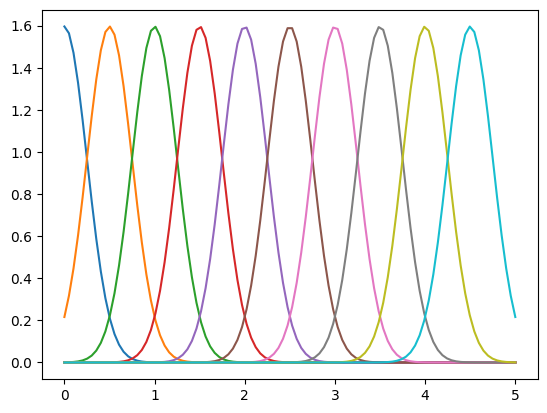

In [180]:
# view the radial embedding
radial = RadialEmbedding(10, 5)
edge_length = torch.linspace(0, 5, 100)
import matplotlib.pyplot as plt
plt.plot(edge_length.detach().numpy(), radial(edge_length).detach().numpy())
plt.show()

Write an equivariant convolutional layer:
    $$
        x'_i=\sigma\left(\sum_{j\in\mathcal{N}_i}x_j\otimes e_{ij}\right).
    $$
    The layers are made up of a tensor product (using e3nn.o3.FullyConnectedTensorProduct) and a non-linearity. You can use torch\_geometric.nn.MessagePassing as a base class, call propagate in the forward method and implement the actual calculations in message(self, x\_j, edge\_attr). The x\_j signifies that this is the node feature of the neighbor that will be summed over. The tensor product is calculated between the x\_j and the edge attributes $e_{ij}$. For the non-linearity to be equivariant, we can't apply an activation function on every element. Instead, we will use the so-called gated non-linearity e3nn.nn.Gate, where the scalar features are split up into two parts: The first part is fed through a SiLU non-linearity, the second part is fed through a sigmoid non-linearity and then multiplied with the higher-$l$ features. Note that you need to change the output irreps of the tensor product to account for the extra scalars needed in the gated non-linearity.

In [181]:
class EquivariantMessagePassing(MessagePassing):
    def __init__(self, irreps_in, irreps_out, num_radial, lmax):
        super().__init__(aggr="add", node_dim=0)
        self.irreps_in = o3.Irreps(irreps_in)
        # self.irreps_out = o3.Irreps(irreps_out) + o3.Irreps("40x0e")
        self.irreps_out = o3.Irreps("168x0e + 32x1o + 8x2e") # "128x0e + 32x1o + 8x2e" + "40x0e" for gated non-linearity
        self.irreps_sh = o3.Irreps.spherical_harmonics(lmax)
        self.irreps_edge = o3.Irreps(f"{num_radial}x0e") + self.irreps_sh
        self.num_radial = num_radial

        self.tp = o3.FullyConnectedTensorProduct(
            self.irreps_in, self.irreps_edge, self.irreps_out, "component"
        )

        self.activation = e3nn.nn.NormActivation(self.irreps_out, torch.nn.Sigmoid())

        self.gate = e3nn.nn.Gate(irreps_scalars="128x0e", act_scalars=[torch.nn.SiLU()], irreps_gates="40x0e", act_gates=[torch.nn.Sigmoid()], irreps_gated="32x1o+8x2e")
        

    def forward(self, x, edge_index, edge_attr, edge_length):
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, edge_length=edge_length)

        return self.gate(out)

    def message(self, x_j, edge_attr, edge_length):

        return self.tp(x_j, torch.cat([edge_attr, edge_length], dim=1))

Combine the embedding and two equivariant convolution layers to obtain an equivariant model. Apply a linear layer to the scalar node features and add them to obtain a prediction for the energy. You can use torch\_geometric.nn.global\_add\_pool.

In [182]:
class EGNN(nn.Module):
    def __init__(self, num_layers, irreps_in, irreps_embedding, irreps_hidden, irreps_out, num_radial, lmax, cutoff):
        super().__init__()
        self.radial_embedding = RadialEmbedding(num_radial, cutoff)
        self.z_embedding = nn.Embedding(9, irreps_embedding.dim)

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(EquivariantMessagePassing(irreps_embedding, irreps_hidden, num_radial, lmax))
            irreps_embedding = irreps_hidden
        
        self.lin = e3nn.o3.Linear(irreps_hidden, irreps_out)


    def forward(self, data):
        z, edge_index, pos = data.z, data.edge_index, data.pos
        
        x = self.z_embedding(z)

        edge_vec = pos[edge_index[0]] - pos[edge_index[1]]
        edge_length = edge_vec.norm(dim=-1)
        # print(edge_length.mean())
        edge_attr = o3.spherical_harmonics(self.layers[0].irreps_sh, edge_vec, normalize=True, normalization='component')
        radial_embedding = self.radial_embedding(edge_length)
        # edge_attr = torch.cat([edge_attr, radial_embedding], dim=-1)

        for layer in self.layers:
            x = layer(x, edge_index, edge_attr, radial_embedding)

        x = self.lin(x)

        energy = global_add_pool(x, data.batch)
        
        return energy

In [183]:
irreps_in = o3.Irreps("1x0e")  # scalar input features
irreps_embedding = o3.Irreps("128x0e")  # embedding features
irreps_hidden = o3.Irreps("128x0e + 32x1o + 8x2e")
irreps_out = o3.Irreps("1x0e")
num_layers = 2
num_radial = 32
lmax = 2
cutoff = 5.0

# Initialize the model
model = EGNN(num_layers, irreps_in, irreps_embedding, irreps_hidden, irreps_out, num_radial, lmax, cutoff)

loss_arr = []
val_loss = []
x_axis = []
val_x_axis = []

/export/home/ggerhart/mambaforge/envs/tensor2/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/export/home/ggerhart/mambaforge/envs/tensor2/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/export/home/ggerhart/mambaforge/envs/tensor2/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `t

In [184]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.energy)
        loss.backward()
        loss_arr.append(loss.item())
        x_axis.append(len(loss_arr))
        optimizer.step()

# Validation function
def validate(loader):
    model.eval()
    error = 0
    with torch.no_grad():
        for data in loader:
            output = model(data)
            error += (output - data.energy).abs().sum().item()
    return error / len(loader.dataset)

# Training loop
for epoch in range(1, 301):
    train()
    val_error = validate(val_loader)
    val_loss.append(val_error)
    val_x_axis.append(epoch * len(train_loader))
    print(f'Epoch: {epoch:03d}, Loss: {loss_arr[-1]:.4f}, Validation MAE: {val_error:.4f}', end='\r')

print('')
# Test the model
test_error = validate(test_loader)
print(f'Test MAE: {test_error:.4f}')

/export/home/ggerhart/mambaforge/envs/tensor2/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/export/home/ggerhart/mambaforge/envs/tensor2/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 300, Loss: 151485.2656, Validation MAE: 22565.0450680000
Test MAE: 20979.6931


Train your model and plot the loss and the validation MAE. State the test MAE. You can use your
train loop from exercise sheet 09

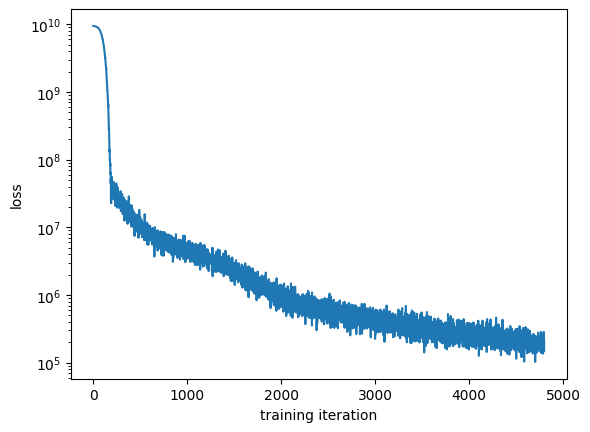

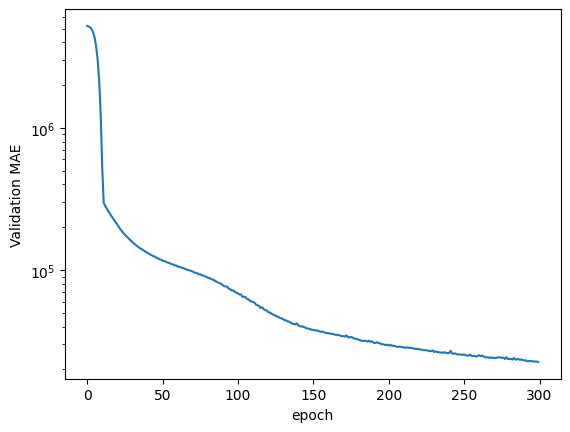

In [185]:
from matplotlib import pyplot as plt

plt.plot(loss_arr, label='train')
plt.yscale('log')
plt.xlabel('training iteration')
plt.ylabel('loss')
plt.show()
plt.plot(val_loss, label='val')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Validation MAE')
plt.show()